In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.metrics import classification_report
from sklearn.utils import class_weight

2025-06-06 13:45:11.264315: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 13:45:11.476341: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-06 13:45:11.655788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749231911.822350   78237 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749231911.865459   78237 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749231912.229175   78237 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
df = pd.read_csv('../../raw_data/twitter_MBTI.csv')

In [4]:
df = df[['text', 'label']]  # Keep only what's necessary
df.dropna(inplace=True)     # Drop rows with missing values

In [5]:
# Create one binary column for each MBTI letter
df['IE'] = df['label'].apply(lambda x: 1 if x[0] == 'i' else 0)
df['NS'] = df['label'].apply(lambda x: 1 if x[1] == 'n' else 0)
df['TF'] = df['label'].apply(lambda x: 1 if x[2] == 't' else 0)
df['JP'] = df['label'].apply(lambda x: 1 if x[3] == 'j' else 0)

In [6]:
# import re

# def clean_posts(text):
#     # Sépare les tweets si concaténés par ||||
#     tweets = text.split("||||")

#     cleaned = []
#     for tweet in tweets:
#         # Supprime les mentions @utilisateur
#         tweet = re.sub(r'@\w+', '', tweet)
#         # Supprime les liens
#         tweet = re.sub(r'http\S+', '', tweet)
#         # Supprime les caractères non alphabétiques (en gardant les espaces)
#         tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
#         # Met en minuscules
#         tweet = tweet.lower()
#         # Supprime les espaces multiples
#         tweet = re.sub(r'\s+', ' ', tweet).strip()
#         cleaned.append(tweet)

#     # Rejoint les tweets nettoyés en une seule chaîne
#     return ". ".join(cleaned)

In [7]:
import re

def clean_posts(text):
    # Split the tweets on ||||
    tweets = text.split("|||")
    cleaned = []

    for tweet in tweets:
        # Remove mentions
        tweet = re.sub(r'@\w+', '', tweet)
        # Remove URLs
        tweet = re.sub(r'http\S+', '', tweet)
        # Normalize unicode quotes and dashes (optional)
        tweet = tweet.replace('’', "'").replace('“', '"').replace('”', '"')
        # Keep basic punctuation, remove other non-letter characters
        tweet = re.sub(r'[^a-zA-Z0-9\s.,!?\'"]', '', tweet)
        # Remove extra whitespace
        tweet = re.sub(r'\s+', ' ', tweet).strip()
        # Lowercase
        tweet = tweet.lower()
        # Append only if not empty
        if tweet:
            cleaned.append(tweet)

    # Join tweets with a period and line break for readability
    return ". ".join(cleaned)

In [8]:
df['clean_text'] = df['text'].apply(clean_posts)

In [9]:
df.head()

,text,label,IE,NS,TF,JP,clean_text
0,@Pericles216 @HierBeforeTheAC @Sachinettiyil T...,intj,1,1,1,1,"the pope is infallible, this is a catholic dog..."
1,@Hispanthicckk Being you makes you look cute||...,intj,1,1,1,1,"being you makes you look cute. on, because the..."
2,@Alshymi Les balles sont réelles et sont tirée...,intj,1,1,1,1,les balles sont relles et sont tires trs rapid...
3,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,1,1,1,1,"i'm like entp but idiotic. hey boy, do you wan..."
4,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1,1,1,1,give it to ... he has pica since childhood. sa...


In [10]:
print(df['clean_text'].iloc[10])

sin. he wants to take a ride on the wild side... but with plushies.. i disagree that they are being presented as unproblematic. i think t. i think there's a reason it's problematic. we're not looking through a lens of norma. do you think they gonna show up for jinki?. manifest it!. i want him to disrespect all over me.... disrespect!. behave!. .... you'd let him touch yer butt.. welp you know what i am going to do.. i am less than average. only the chicago river. the disrespect!. could you imagine me without a budget.... if anyone gets a line on be the sun pickets, specifically vernon, please give me a heads up. thanks!. looking cute as always!. he'll be good in the wind and the rain.... like when the dimples come out it's like sir... ask for anything.. i'm happy when people do what brings them joy. if it's a book, a film, listening to music or just taking a walk do. oh. he's rude.. we all want to get a grip.... i've been around for so many.. dirty ones.. love as thou wilt.. if only fo

In [11]:
print(f"balance of the target ie : {df['IE'].value_counts(normalize=True)}")
print(f"balance of the target ns :{df['NS'].value_counts(normalize=True)}")
print(f"balance of the target tf :{df['TF'].value_counts(normalize=True)}")
print(f"balance of the target jp :{df['JP'].value_counts(normalize=True)}")

balance of the target ie : IE
1    0.671873
0    0.328127
Name: proportion, dtype: float64
balance of the target ns :NS
1    0.7725
0    0.2275
Name: proportion, dtype: float64
balance of the target tf :TF
0    0.588401
1    0.411599
Name: proportion, dtype: float64
balance of the target jp :JP
0    0.559083
1    0.440917
Name: proportion, dtype: float64


In [12]:
df['text_length_words'] = df['clean_text'].str.split().apply(len)

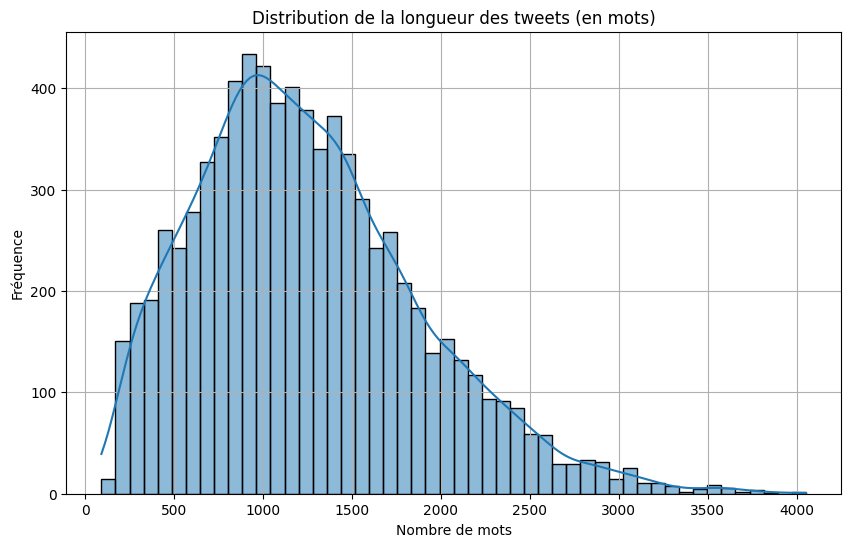

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(df['text_length_words'], bins=50, kde=True)
plt.title("Distribution de la longueur des tweets (en mots)")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.grid(True)
plt.show()

In [14]:
df = df[df['clean_text'].apply(lambda x: len(x.split()) < 1500 and len(x.split()) > 500)].reset_index(drop=True)

In [15]:
df.describe()

,IE,NS,TF,JP,text_length_words
count,4583.000000,4583.000000,4583.000000,4583.000000,4583.000000
mean,0.670521,0.762601,0.401702,0.413921,1017.560986
std,0.470075,0.425535,0.490296,0.492588,273.105957
min,0.000000,0.000000,0.000000,0.000000,501.000000
25%,0.000000,1.000000,0.000000,0.000000,799.000000
50%,1.000000,1.000000,0.000000,0.000000,1016.000000
75%,1.000000,1.000000,1.000000,1.000000,1246.500000
max,1.000000,1.000000,1.000000,1.000000,1499.000000


In [16]:
df.head()

,text,label,IE,NS,TF,JP,clean_text,text_length_words
0,@Hispanthicckk Being you makes you look cute||...,intj,1,1,1,1,"being you makes you look cute. on, because the...",898
1,"I'm like entp but idiotic|||Hey boy, do you wa...",intj,1,1,1,1,"i'm like entp but idiotic. hey boy, do you wan...",1122
2,@kaeshurr1 Give it to @ZargarShanif ... He has...,intj,1,1,1,1,give it to ... he has pica since childhood. sa...,863
3,proud of this one it goes hard https://t.co/RQ...,intj,1,1,1,1,proud of this one it goes hard. fucking disgus...,615
4,@Ieokuras so amazing!|||@hxhrats @ETTUKILLUG w...,intj,1,1,1,1,"so amazing!. well... mozart was a composer, to...",933


In [17]:
df['clean_text'][0]

'being you makes you look cute. on, because then i can have the fun of peeling it off.... "bored now.". less is more. sweetie, i\'d suck your dick even if there were no shake inducement. leg day? looks more like crotch day. which is not a bad thing. goth pairs figure skating. the west wing, the closer, mash, orphan black, sense8. are you a good spice, or a bad spice?. it looks enticing.... i\'m tired of corporations profiting from the lgbtq community while actively funding our persecution. join me in ca. do you support disney funding antilgbtq politicians? they still use you in their advertising.. do you support disney funding antilgbtq politicians? they still use you in their advertising.. do you support disney funding antilgbtq politicians? they still use you in their advertising.. do you support disney funding antilgbtq politicians? they still use you in their advertising.. do you support disney funding antilgbtq politicians? they still use you in their advertising.. do you support 

In [18]:
!pip install xgboost

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

In [20]:
custom_stopwords = {
    "intj", "intp", "entj", "entp",
    "infj", "infp", "enfj", "enfp",
    "istj", "isfj", "estj", "esfj",
    "istp", "isfp", "estp", "esfp", "https"
}

# Fusionner avec les stopwords anglais
combined_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stopwords))

vectorizer = TfidfVectorizer(max_features=20000,
                             ngram_range=(1, 2),
                             stop_words=combined_stopwords)

X = vectorizer.fit_transform(df["clean_text"])

In [21]:
y_tf = df["TF"]
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, y_tf, test_size=0.2, random_state=42)
model_tf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_tf.fit(X_train_tf, y_train_tf)
y_pred_tf = model_tf.predict(X_test_tf)
print(classification_report(y_test_tf, y_pred_tf))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:46:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.67      0.79      0.73       554
           1       0.57      0.42      0.48       363

    accuracy                           0.64       917
   macro avg       0.62      0.60      0.60       917
weighted avg       0.63      0.64      0.63       917



In [22]:
# Get feature importances
importances_tf = model_tf.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_tf = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_tf = list(zip(feature_names_tf, importances_tf))

# Sort by importance
word_importances_tf = sorted(word_importances_tf, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_tf[:20]:
    print(f"{word}: {importance:.4f}")

hat: 0.0066
studying: 0.0046
google: 0.0045
ahhh: 0.0040
universe: 0.0037
joined: 0.0035
rumors: 0.0035
dick: 0.0035
friday: 0.0034
sending: 0.0034
yall think: 0.0034
villains: 0.0033
insecure: 0.0032
summer: 0.0032
married: 0.0031
tour: 0.0031
movie: 0.0031
everybody: 0.0031
hobby: 0.0030
doc: 0.0029


In [23]:
y_ie = df["IE"]
X_train_ie, X_test_ie, y_train_ie, y_test_ie = train_test_split(X, y_ie, test_size=0.2, random_state=42)
model_ie = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_ie.fit(X_train_ie, y_train_ie)
y_pred_ie = model_ie.predict(X_test_ie)
print(classification_report(y_test_ie, y_pred_ie))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:47:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.52      0.23      0.32       291
           1       0.72      0.90      0.80       626

    accuracy                           0.69       917
   macro avg       0.62      0.56      0.56       917
weighted avg       0.65      0.69      0.65       917



In [24]:
# Get feature importances
importances_ie = model_ie.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ie = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ie = list(zip(feature_names_ie, importances_ie))

# Sort by importance
word_importances_ie = sorted(word_importances_ie, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ie[:20]:
    print(f"{word}: {importance:.4f}")

surrounded: 0.0042
la: 0.0041
raya: 0.0041
gift: 0.0041
questions: 0.0040
emotionally: 0.0040
ako na: 0.0040
gay: 0.0039
loved: 0.0039
people getting: 0.0037
bi: 0.0037
relationship: 0.0037
ms: 0.0036
power: 0.0035
posting: 0.0035
dumb: 0.0035
exact: 0.0034
finished: 0.0034
ate: 0.0034
mbti: 0.0033


In [25]:
y_ns = df["NS"]
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X, y_ns, test_size=0.2, random_state=42)
model_ns = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_ns.fit(X_train_ns, y_train_ns)
y_pred_ns = model_ns.predict(X_test_ns)
print(classification_report(y_test_ns, y_pred_ns))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:48:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.40      0.13      0.20       210
           1       0.79      0.94      0.86       707

    accuracy                           0.76       917
   macro avg       0.59      0.54      0.53       917
weighted avg       0.70      0.76      0.71       917



In [26]:
# Get feature importances
importances_ns = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_ns = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_ns = list(zip(feature_names_ns, importances_ns))

# Sort by importance
word_importances_ns = sorted(word_importances_ns, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_ns[:20]:
    print(f"{word}: {importance:.4f}")

cutie: 0.0061
thoughts: 0.0058
piercing: 0.0053
taehyun: 0.0053
la: 0.0053
video: 0.0052
know thing: 0.0049
moot: 0.0048
walang: 0.0046
earlier: 0.0046
enstars: 0.0046
february: 0.0045
press: 0.0044
cursed: 0.0044
insta: 0.0044
14: 0.0040
brownies: 0.0040
extremely: 0.0040
run: 0.0039
sounds good: 0.0039


In [27]:
y = df["NS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Dealing with class imbalanced
num_pos = sum(y_train)
num_neg = len(y_train) - num_pos
scale = num_neg / num_pos

model = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale  # 👈 Boosts minority class
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:48:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.31      0.20      0.25       210
           1       0.79      0.86      0.82       707

    accuracy                           0.71       917
   macro avg       0.55      0.53      0.53       917
weighted avg       0.68      0.71      0.69       917



In [28]:
y_jp = df["JP"]
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42)
model_jp = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_jp.fit(X_train_jp, y_train_jp)
y_pred_jp = model_jp.predict(X_test_jp)
print(classification_report(y_test_jp, y_pred_jp))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:49:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.66      0.78      0.72       534
           1       0.60      0.45      0.51       383

    accuracy                           0.64       917
   macro avg       0.63      0.61      0.61       917
weighted avg       0.64      0.64      0.63       917



In [29]:
# Get feature importances
importances_jp = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_jp = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_jp = list(zip(feature_names_jp, importances_jp))

# Sort by importance
word_importances_jp = sorted(word_importances_jp, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_jp[:20]:
    print(f"{word}: {importance:.4f}")

cutie: 0.0061
thoughts: 0.0058
piercing: 0.0053
taehyun: 0.0053
la: 0.0053
video: 0.0052
know thing: 0.0049
moot: 0.0048
walang: 0.0046
earlier: 0.0046
enstars: 0.0046
february: 0.0045
press: 0.0044
cursed: 0.0044
insta: 0.0044
14: 0.0040
brownies: 0.0040
extremely: 0.0040
run: 0.0039
sounds good: 0.0039


In [30]:
custom_stopwords = [
    "intj", "intp", "entj", "entp",
    "infj", "infp", "enfj", "enfp",
    "istj", "isfj", "estj", "esfj",
    "istp", "isfp", "estp", "esfp"
]

vectorizer = TfidfVectorizer(max_features=20000,
                             ngram_range=(1, 3),
                             stop_words=custom_stopwords)

X = vectorizer.fit_transform(df["text"])

In [31]:
y_jp = df["JP"]
X_train_jp, X_test_jp, y_train_jp, y_test_jp = train_test_split(X, y_jp, test_size=0.2, random_state=42)
model_jp = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model_jp.fit(X_train_jp, y_train_jp)
y_pred_jp = model_jp.predict(X_test_jp)
print(classification_report(y_test_jp, y_pred_jp))

/home/tanguy/.pyenv/versions/vibe/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [13:51:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.63      0.77      0.70       534
           1       0.54      0.37      0.44       383

    accuracy                           0.61       917
   macro avg       0.59      0.57      0.57       917
weighted avg       0.59      0.61      0.59       917



In [32]:
# Get feature importances
importances_jp = model_ns.feature_importances_  # shape: (num_features,)

# Get the vocabulary (i.e., words) from the vectorizer
feature_names_jp = vectorizer.get_feature_names_out()

# Combine words with importances
word_importances_jp = list(zip(feature_names_jp, importances_jp))

# Sort by importance
word_importances_jp = sorted(word_importances_jp, key=lambda x: x[1], reverse=True)

# Show top 20 most important words
for word, importance in word_importances_jp[:20]:
    print(f"{word}: {importance:.4f}")

daw: 0.0061
trop: 0.0058
ri: 0.0053
time in: 0.0053
lonely: 0.0053
what makes: 0.0052
little too: 0.0049
off of: 0.0048
who the: 0.0046
experiences: 0.0046
file: 0.0046
from her: 0.0045
seattle: 0.0044
da: 0.0044
its: 0.0044
2017: 0.0040
boring: 0.0040
for mtvlafandomexo: 0.0040
sry: 0.0039
the thing: 0.0039


In [33]:
ie_pred = ['i' if x == 1 else 'e' for x in y_pred_ie]
ns_pred = ['n' if x == 1 else 's' for x in y_pred_ns]
tf_pred = ['t' if x == 1 else 'f' for x in y_pred_tf]
jp_pred = ['j' if x == 1 else 'p' for x in y_pred_jp]

y_test_ie_l = ['i' if x == 1 else 'e' for x in y_test_ie]
y_test_ns_l = ['n' if x == 1 else 's' for x in y_test_ns]
y_test_tf_l = ['t' if x == 1 else 'f' for x in y_test_tf]
y_test_jp_l = ['j' if x == 1 else 'p' for x in y_test_jp]

In [34]:
# Create DataFrame
df_pred = pd.DataFrame({
    'IE': ie_pred,
    'NS': ns_pred,
    'TF': tf_pred,
    'JP': jp_pred,
    'IE_test': y_test_ie_l,
    'NS_test': y_test_ns_l,
    'TF_test': y_test_tf_l,
    'JP_test': y_test_jp_l
})

df_pred['MBTI'] = df_pred['IE'] + df_pred['NS'] + df_pred['TF'] + df_pred['JP']
df_pred['MBTI_test'] = df_pred['IE_test'] + df_pred['NS_test'] + df_pred['TF_test'] + df_pred['JP_test']

In [35]:
df_pred

,IE,NS,TF,JP,IE_test,NS_test,TF_test,JP_test,MBTI,MBTI_test
0,e,n,t,p,e,n,t,p,entp,entp
1,i,n,t,p,i,n,f,p,intp,infp
2,i,n,f,p,i,n,t,p,infp,intp
3,i,n,f,p,i,n,f,p,infp,infp
4,i,n,f,j,i,n,f,j,infj,infj
...,...,...,...,...,...,...,...,...,...,...
912,i,n,f,p,e,n,f,j,infp,enfj
913,i,n,f,j,i,s,t,j,infj,istj
914,i,n,f,p,i,s,f,j,infp,isfj
915,e,n,f,p,i,n,f,p,enfp,infp


In [36]:
accuracy = (df_pred['MBTI'] == df_pred['MBTI_test']).mean() * 100

print(f"Pourcentage de MBTI correctement prédits : {accuracy:.2f}%")

Pourcentage de MBTI correctement prédits : 23.01%


In [37]:
accuracy_ie = (df_pred['IE'] == df_pred['IE_test']).mean() * 100
accuracy_ns = (df_pred['NS'] == df_pred['NS_test']).mean() * 100
accuracy_tf = (df_pred['TF'] == df_pred['TF_test']).mean() * 100
accuracy_jp = (df_pred['JP'] == df_pred['JP_test']).mean() * 100


print(f"Pourcentage de IE correctement prédits : {accuracy_ie:.2f}%")
print(f"Pourcentage de NS correctement prédits : {accuracy_ns:.2f}%")
print(f"Pourcentage de TF correctement prédits : {accuracy_tf:.2f}%")
print(f"Pourcentage de JP correctement prédits : {accuracy_jp:.2f}%")

Pourcentage de IE correctement prédits : 68.70%
Pourcentage de NS correctement prédits : 75.57%
Pourcentage de TF correctement prédits : 64.34%
Pourcentage de JP correctement prédits : 60.52%


In [38]:
df_last_model = pd.DataFrame({
        'IE': y_pred_ie,
        'NS': y_pred_ns,
        'TF': y_pred_tf,
        'JP': y_pred_jp,
        'IE_test': y_test_ie,
        'NS_test': y_test_ns,
        'TF_test': y_test_tf,
        'JP_test': y_test_jp
    })

In [39]:
df_last_model

,IE,NS,TF,JP,IE_test,NS_test,TF_test,JP_test
1207,0,1,1,0,0,1,1,0
3910,1,1,1,0,1,1,0,0
1183,1,1,0,0,1,1,1,0
100,1,1,0,0,1,1,0,0
3879,1,1,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...
1717,1,1,0,0,0,1,0,1
3960,1,1,0,1,1,0,1,1
1803,1,1,0,0,1,0,0,1
3737,0,1,0,0,1,1,0,0


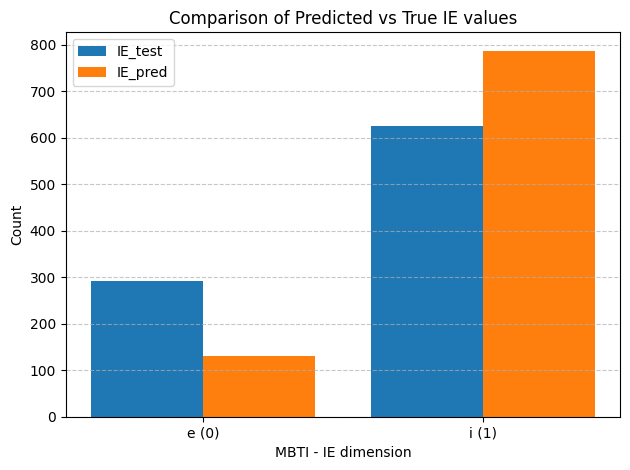

In [40]:
# Count the values of 0 and 1 for prediction and true labels
ie_pred_counts = df_last_model['IE'].value_counts().sort_index()
ie_test_counts = df_last_model['IE_test'].value_counts().sort_index()

# Define labels
labels = ['e (0)', 'i (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [ie_test_counts.get(i, 0) for i in range(2)], width=0.4, label='IE_test')
plt.bar([i + 0.2 for i in x], [ie_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='IE_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - IE dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True IE values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

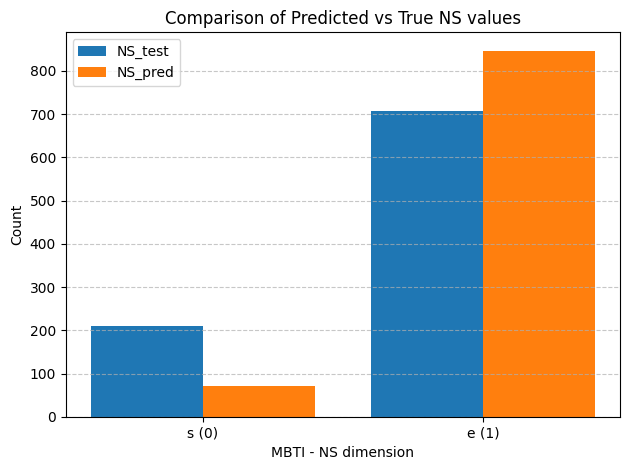

In [41]:
# Count the values of 0 and 1 for prediction and true labels
ns_pred_counts = df_last_model['NS'].value_counts().sort_index()
ns_test_counts = df_last_model['NS_test'].value_counts().sort_index()

# Define labels
labels = ['s (0)', 'e (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [ns_test_counts.get(i, 0) for i in range(2)], width=0.4, label='NS_test')
plt.bar([i + 0.2 for i in x], [ns_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='NS_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - NS dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True NS values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

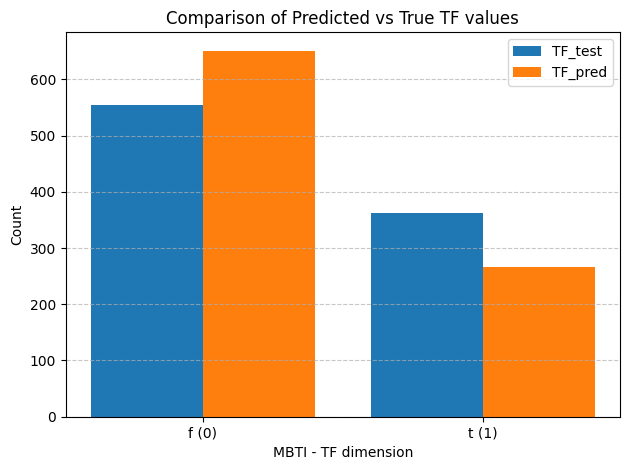

In [42]:
# Count the values of 0 and 1 for prediction and true labels
tf_pred_counts = df_last_model['TF'].value_counts().sort_index()
tf_test_counts = df_last_model['TF_test'].value_counts().sort_index()

# Define labels
labels = ['f (0)', 't (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [tf_test_counts.get(i, 0) for i in range(2)], width=0.4, label='TF_test')
plt.bar([i + 0.2 for i in x], [tf_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='TF_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - TF dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True TF values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

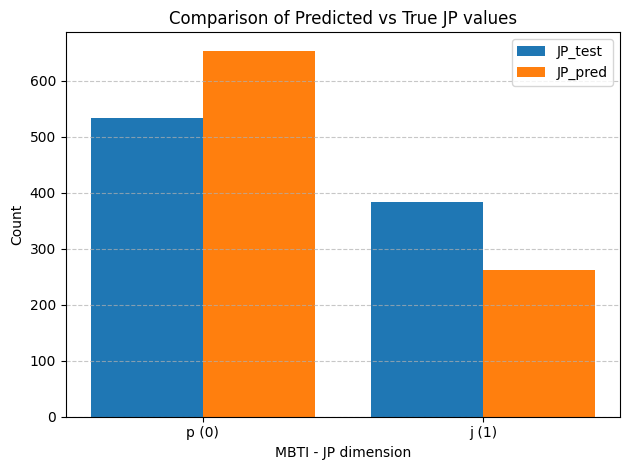

In [43]:
# Count the values of 0 and 1 for prediction and true labels
jp_pred_counts = df_last_model['JP'].value_counts().sort_index()
jp_test_counts = df_last_model['JP_test'].value_counts().sort_index()

# Define labels
labels = ['p (0)', 'j (1)']
x = range(len(labels))

# Bar plot side by side
plt.bar([i - 0.2 for i in x], [jp_test_counts.get(i, 0) for i in range(2)], width=0.4, label='JP_test')
plt.bar([i + 0.2 for i in x], [jp_pred_counts.get(i, 0) for i in range(2)], width=0.4, label='JP_pred')

plt.xticks(x, labels)
plt.xlabel('MBTI - JP dimension')
plt.ylabel('Count')
plt.title('Comparison of Predicted vs True JP values')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()